# 分割节点和边

In [ ]:
import pandas as pd
import os
from tqdm import tqdm
'''
split link
'''
if not os.path.exists("splitEdge"):
    os.mkdir("splitEdge")

df = pd.read_csv('./data/Link.csv')

for key, group in tqdm(df.groupby("relation")):

    # group = group.drop(columns='relation')
    group.reset_index(drop=True, inplace=True)
    group.rename(columns={"relation": ":TYPE",
                          "source": ":START_ID",
                          "target": ":END_ID"},  inplace=True)

    if key in ["r_cert", "r_subdomain", "r_request_jump", "r_dns_a"]:
        group.insert(group.shape[1], "weight:int", 2)
    elif key in ["r_cert_chain", "r_cname"]:
        group.insert(group.shape[1], "weight:int", 1)
    group.to_csv(
        './splitEdge/' + key + '.csv', index=False, encoding='utf_8_sig')

In [ ]:
'''
split node
'''
# get work Path
path = os.getcwd()
# read csv file
dataFrame = pd.read_csv(path+"\\data\\Node.csv")
community = pd.read_csv('./data/node-community.csv')
dataFrame = pd.merge(dataFrame, community, left_on='id',
                right_on='id', how='left')
del community
# group
groups = dataFrame.groupby("type")

Domain_gp = groups.get_group("Domain")
IP_gp = groups.get_group("IP")
Cert_gp = groups.get_group("Cert")
Register_Name_gp = groups.get_group("Whois_Name")
Register_Email_gp = groups.get_group("Whois_Email")
Register_Phone_gp = groups.get_group("Whois_Phone")
IPC_gp = groups.get_group("IP_C")
ASN_gp = groups.get_group("ASN")

# split DF
Domain = Domain_gp.set_index("id")
IP = IP_gp.drop("industry", axis=1).set_index("id")
Cert = Cert_gp.drop("industry", axis=1).set_index("id")
Register_Name = Register_Name_gp.drop("industry", axis=1).set_index("id")
Register_Email = Register_Email_gp.drop("industry", axis=1).set_index("id")
Register_Phone = Register_Phone_gp.drop("industry", axis=1).set_index("id")
IPC = IPC_gp.drop("industry", axis=1).set_index("id")
ASN = ASN_gp.drop("industry", axis=1).set_index("id")

if not os.path.exists("splitNode"):
    os.mkdir("splitNode")
Domain.to_csv(path+"\\splitNode\\Domain.csv", encoding='utf_8_sig')
print("Domain finished")
IP.to_csv(path+"\\splitNode\\IP.csv", encoding='utf_8_sig')
print("IP finished")
Cert.to_csv(path+"\\splitNode\\Cert.csv", encoding='utf_8_sig')
print("Domain finished")
Register_Name.drop(columns=["community"], inplace=True)
Register_Name.to_csv(path+"\\splitNode\\Register_Name.csv",
                     encoding='utf_8_sig')
print("Register_Name finished")
Register_Email.drop(columns=["community"], inplace=True)
Register_Email.to_csv(
    path+"\\splitNode\\Register_Email.csv", encoding='utf_8_sig')
print("Register_Email finished")
Register_Phone.drop(columns=["community"], inplace=True)
Register_Phone.to_csv(
    path+"\\splitNode\\Register_Phone.csv", encoding='utf_8_sig')
print("Register_Phone finished")
IPC.drop(columns=["community"], inplace=True)
IPC.to_csv(path+"\\splitNode\\IPC.csv", encoding='utf_8_sig')
print("IPC finished")
ASN.drop(columns=["community"], inplace=True)
ASN.to_csv(path+"\\splitNode\\ASN.csv", encoding='utf_8_sig')
print("ASN finished")

# 合并节点，重命名

In [ ]:
from unittest import case
import pandas as pd
import re
import os
from shutil import copyfile
from tqdm import tqdm
tqdm.pandas(desc="split industry")

dict_map = {
    "A": "porn",
    "B": "gambling",
    "C": "fraud",
    "D": "drug",
    "E": "gun",
    "F": "hacker",
    "G": "trading",
    "H": "pay",
    "I": "other"
}
nodepath = './splitNode/'
edgepath = './splitEdge/'
saveNodePath = './processedData/Node/'
saveEdgePath = './processedData/Edge/'
if not os.path.exists(saveNodePath):
    os.makedirs(saveNodePath)
if not os.path.exists(saveEdgePath):
    os.makedirs(saveEdgePath)

### 将email，phone，name作为属性添加到domain上，并将industry拆分成7种犯罪属性

In [ ]:
'''
Merge domain and (email, name, phone)
Split industry into 9 attributes
'''
def apply_split(row):
    res = re.findall('[A-Z]', row['industry'])
    for s in res:
        row[dict_map[s]] = True
    row["weight:int"] = len(res)
    return row

df = pd.read_csv(nodepath + 'Domain.csv')

# merge domain & email
df_whois_Email = pd.read_csv(edgepath + 'r_whois_email.csv')
df_whois_Email.drop_duplicates(
    subset=[':START_ID'], keep='first', inplace=True)
df_Email = pd.read_csv(nodepath + 'Register_Email.csv')

df = pd.merge(df, df_whois_Email, left_on='id',
              right_on=':START_ID', how='left')
df = pd.merge(df, df_Email, left_on=':END_ID', right_on='id', how='left')

df = df.drop(columns=[":TYPE", ":START_ID", ":END_ID", "type_y"])
df.rename(columns={"id_x": "id",
                   "id_y": "email_id",
                   "name_x": "name",
                   "type_x": "type",
                   "name_y": "email",
                   "community": "community:int"},  inplace=True)
print(df.columns)

# merge domain & name
df_whois_Name = pd.read_csv(edgepath + 'r_whois_name.csv')
df_whois_Name.drop_duplicates(subset=[':START_ID'], keep='first', inplace=True)
df_Name = pd.read_csv(nodepath + 'Register_Name.csv')

df = pd.merge(df, df_whois_Name, left_on='id',
              right_on=':START_ID', how='left')
df = pd.merge(df, df_Name, left_on=':END_ID', right_on='id', how='left')

df = df.drop(columns=[":TYPE", ":START_ID", ":END_ID", "type_y"])
df.rename(columns={"id_x": "id",
                   "id_y": "register_id",
                   "name_x": "name",
                   "type_x": "type",
                   "name_y": "register"},  inplace=True)
print(df.columns)

# merge domain & phone
df_whois_Phone = pd.read_csv(edgepath + 'r_whois_Phone.csv')
df_whois_Phone.drop_duplicates(
    subset=[':START_ID'], keep='first', inplace=True)
df_Phone = pd.read_csv(nodepath + 'Register_Phone.csv')

df = pd.merge(df, df_whois_Phone, left_on='id',
              right_on=':START_ID', how='left')
df = pd.merge(df, df_Phone, left_on=':END_ID', right_on='id', how='left')

df = df.drop(columns=[":TYPE", ":START_ID", ":END_ID", "type_y"])
df.rename(columns={"id_x": "id:ID",
                   "id_y": "phone_id",
                   "name_x": "name",
                   "type_x": ":LABEL",
                   "name_y": "phone"},  inplace=True)
print(df.columns)



for insert_c in list(dict_map.values()):
    df.insert(df.shape[1], insert_c, False)

df.insert(df.shape[1], "weight:int", 0)

# df.apply的tqdm写法，用来显示进度条
df = df.progress_apply(apply_split, axis=1)
df = df.drop(columns="industry")
df["community:int"] = df["community:int"].astype(int)
df.to_csv(saveNodePath + 'Domain.csv', index=False, encoding="utf-8-sig")

### 将asn，ipc作为属性添加到IP上

In [ ]:
'''
Merge IP and (asn, cidr)
'''
df = pd.read_csv(nodepath + 'IP.csv')

# merge IP & ASN
df_r_asn = pd.read_csv(edgepath + 'r_asn.csv')
df_r_asn.drop_duplicates(subset=[':START_ID'], keep='first', inplace=True)
df_ASN = pd.read_csv(nodepath + 'ASN.csv')

df = pd.merge(df, df_r_asn, left_on='id', right_on=':START_ID', how='left')
df = pd.merge(df, df_ASN, left_on=':END_ID', right_on='id', how='left')


df = df.drop(columns=[":TYPE", ":START_ID", ":END_ID", "type_y"])
df.rename(columns={"id_x": "id",
                   "id_y": "asn_id",
                   "name_x": "name",
                   "type_x": "type",
                   "name_y": "asn",
                   "community": "community:int"},  inplace=True)
print(df.columns)

# merge IP & IPC
df_cidr = pd.read_csv(edgepath + 'r_cidr.csv')
df_cidr.drop_duplicates(subset=[':START_ID'], keep='first', inplace=True)
df_IPC = pd.read_csv(nodepath + 'IPC.csv')

df = pd.merge(df, df_cidr, left_on='id', right_on=':START_ID', how='left')
df = pd.merge(df, df_IPC, left_on=':END_ID', right_on='id', how='left')


df = df.drop(columns=[":TYPE", ":START_ID", ":END_ID", "type_y"])
df.rename(columns={"id_x": "id:ID",
                   "id_y": "ipc_id",
                   "name_x": "name",
                   "type_x": ":LABEL",
                   "name_y": "ipc"},  inplace=True)
print(df.columns)
df["community:int"] = df["community:int"].astype(int)
df.to_csv(saveNodePath + 'IP.csv', index=False, encoding="utf-8-sig")

### 重命名cert

In [ ]:
'''
Rename Cert
'''
df_cert = pd.read_csv(nodepath + 'Cert.csv')
df_cert.rename(columns={"id": "id:ID",
                        "type": ":LABEL",
                        "community": "community:int"},  inplace=True)
print(df_cert.columns)
df_cert["community:int"] = df_cert["community:int"].astype(int)
df_cert.to_csv(saveNodePath + 'Cert.csv',
               index=False, encoding="utf-8-sig")

### 重命名link

In [ ]:
'''
Select Edge
'''
splitEdge = os.listdir(edgepath)
for file in tqdm(splitEdge):
    if file == 'r_cert_chain.csv':
        copyfile(edgepath + file, saveEdgePath + 'cert-cert.csv')
    elif file == 'r_cert.csv':
        copyfile(edgepath + file, saveEdgePath + 'domain-cert.csv')
    elif file == 'r_cname.csv':
        copyfile(edgepath + file, saveEdgePath + 'domain-cname.csv')
    elif file == 'r_dns_a.csv':
        copyfile(edgepath + file, saveEdgePath + 'domain-IP.csv')
    elif file == 'r_request_jump.csv':
        copyfile(edgepath + file, saveEdgePath + 'domain-domain.csv')
    elif file == 'r_subdomain.csv':
        copyfile(edgepath + file, saveEdgePath + 'domain-subdomain.csv')
    else:
        continue

# （没用）合并社区

In [ ]:
import pandas as pd
import os
import csv
from tqdm import tqdm

node = pd.read_csv('./data/Node.csv')
community = pd.read_csv('./data/node-community.csv')
node = pd.merge(node, community, left_on='id',
                right_on='id', how='left')
# node.drop(columns=["name", "type", "industry"], inplace=True)
del community

with open('modify.csv','a+', encoding='utf-8-sig',newline='') as f:#r为标识符，表示只读
    writer = csv.writer(f)
    # cname = pd.read_csv(
    #     './processedData/Edge/domain-cname.csv').drop(columns=[":TYPE", "weight:int"])
    # for i, row in tqdm(cname.iterrows()):
    #     c_start = node[node["id"] == row[":START_ID"]]["community"].values[0]
    #     c_end = node[node["id"] == row[":END_ID"]]["community"].values[0]
    #     if(c_start != c_end):
    #         writer.writerow([c_end, c_start])
    #         node.loc[node["community"] == c_end, ["community"]] = c_start
        

    subdomain = pd.read_csv(
        './processedData/Edge/domain-subdomain.csv').drop(columns=[":TYPE", "weight:int"])
    for i, row in tqdm(subdomain.iterrows()):
        s_start = node[node["id"] == row[":START_ID"]]["community"].values[0]
        s_end = node[node["id"] == row[":END_ID"]]["community"].values[0]
        if(s_start != s_end):
            writer.writerow([s_end, s_start])
            node.loc[node["community"] == s_end, ["community"]] = s_start
        
    node.to_csv('CommunityNode.csv', index=False, encoding="utf-8-sig")

# 社区连接图数据

In [ ]:
import pandas as pd

df = pd.concat([pd.read_csv('./processedData/Edge/cert-cert.csv', encoding="utf-8"),
                pd.read_csv('./processedData/Edge/domain-cert.csv', encoding="utf-8"),
                pd.read_csv('./processedData/Edge/domain-cname.csv', encoding="utf-8"),
                pd.read_csv('./processedData/Edge/domain-domain.csv', encoding="utf-8"),
                pd.read_csv('./processedData/Edge/domain-IP.csv', encoding="utf-8"),
                pd.read_csv('./processedData/Edge/domain-subdomain.csv', encoding="utf-8")])
df.columns = ['type', 'start', 'end', 'weight']
df = pd.DataFrame(df, columns=['start', 'end'])
df_Start = pd.DataFrame(df, columns=['start'])
df_End = pd.DataFrame(df, columns=['end'])

df_community_start = pd.read_csv(
    './data/node-community.csv', encoding="utf-8")
df_community_end = pd.read_csv('./data/node-community.csv', encoding="utf-8")
df_community_start.columns = ['start', 'community']
df_community_end.columns = ['end', 'community']

start = pd.merge(df_Start, df_community_start, how='left')
end = pd.merge(df_End, df_community_end, how='left')
start.columns = ['start', 'communityS']
end.columns = ['end', 'communityE']
result = pd.concat([start, end], axis=1)
print(result)
SR = []
ER = []
for index, row in result.iterrows():
    if(row['communityS'] != row['communityE']):
        SR.append(row['communityS'])
        ER.append(row['communityE'])

Final = pd.DataFrame({'source': SR,
                      'target': ER})
dfFinal = Final.drop_duplicates()
dfFinal.to_csv('community2community.csv', index=False, encoding="utf-8-sig")


# 去掉社区节点数小于等于3的社区连接

In [ ]:
import pandas as pd

c2c = pd.read_csv('./data/community2community.csv')
c3 = pd.read_csv('./data/community-nodes-3.csv')
c2c = c2c[(c2c.source.isin(c3.communityId.values))&(c2c.target.isin(c3.communityId.values))].reset_index(drop=True)

c2c.to_csv('community2community-3.csv', index=False, encoding="utf-8-sig")

In [ ]:
# csv转json
import pandas as pd
df = pd.read_csv('./data/community2community-3.csv')
df.to_json('./app/public/community_link.json', orient="records")

In [ ]:
# 社区节点加邻居
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc="neighbour")
def fn(row):
  res = set()
  data = {'id':[row["id"]]}
  _ = pd.DataFrame(data)
  _ = pd.merge(_, _df, how='left', left_on="id", right_on="source").drop(columns=["source"])
  _ = pd.merge(_, _df, how='left', left_on="id", right_on="target").drop(columns=["target_y"]).dropna(axis=1,how='all')
  if 'source' in _.columns:
    res.update(_["source"].values)
  if 'target_x' in _.columns:
    res.update(_["target_x"].values)
  row["neighbour"] = list(res)
  return row
df = pd.read_json('./data/community_node.json')
_df = pd.read_json('./data/community_link.json')
df = df.progress_apply(fn, axis=1)


In [ ]:
# df.to_json('./data/community_node1.json', orient="records")
# df[df['neighbour'].str.len()!=0].to_json('./data/community_node2.json', orient="records")

In [ ]:
# 适配lineup porn,gambling,fraud,drug,gun,hacker,hacker,pay,other
df = df[df['neighbour'].str.len()!=0].drop(columns=["Domain", "Cert"])
df.to_json('./data/community_node2.json', orient="records")
print(df.columns)

In [ ]:
df["wrong_list"] = df[["porn","gambling","fraud","drug","gun","hacker","trading","pay","other"]].values.tolist()
test = df.drop(columns=["porn","gambling","fraud","drug","gun","hacker","trading","pay","other"], inplace=False)
test.to_json('./data/community_node3.json', orient="records")
print(test.columns)

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc="")
link = pd.read_json('./data/community_link.json')
node = pd.read_json('./data/community_node.json')
def addNode2Link(row):
  row['sourceNode'] = node[node['id']==row['source']]
  row['targetNode'] = node[node['id']==row['target']]
  return row
link = link.progress_apply(addNode2Link, axis=1)
link.to_json('./data/community_link.json', orient="records")


100%|██████████| 10665/10665 [00:00<00:00, 14458.09it/s]


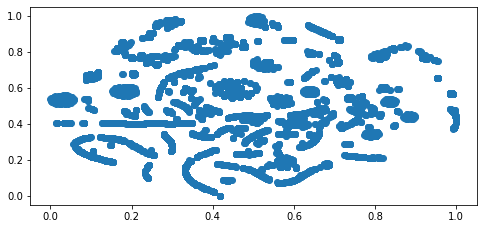

In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc="")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

lu = []
label = []
def node2onehot(row):
  li=[]
  li.append(round(row['node_num']/(row['wrong_num']+1), 2))
  for i in row['wrong_list']:
    if(i>1):
      li.append(1)
    else:
      li.append(0)
  label.append([row['id']])
  lu.append(li)
  return row
node = pd.read_json('./data/community_node.json')
node.progress_apply(node2onehot, axis=1)
X = np.array(lu)
ts = TSNE(n_components=2)
y = ts.fit_transform(X)
x_min, x_max = np.min(y, 0), np.max(y, 0)
y = (y - x_min) / (x_max - x_min)
res = np.concatenate((y, np.array(label)), axis=1)
dic = {}
dic['data']=res.tolist()
dict_json = json.dumps(dic)
with open('file.json','w+') as file:
  file.write(dict_json)
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 1, 2)
plt.scatter(y[:, 0], y[:, 1], cmap=plt.cm.Spectral)
plt.show()